# grok improved version

**Major Improvement**  
1. **Handle Categorical Variables**:  
Use `OneHotEncoder` to transform 'Prime', 'DOMAIN', and 'FRAME' into numerical representations suitable for the model.  
3. **Use a Pipeline**:  
Integrate preprocessing and modeling into a Pipeline to streamline the workflow and prevent data leakage.  
4. **Stratified Splitting**:  
The original code already uses `stratify=y`, which is good for maintaining class balance. We’ll keep this.  
5. **Enhanced Visualizations**:  
Adjust the feature importance plot to reflect the transformed feature names after preprocessing.  
6. **Best Practices**:  
Add better error handling, comments, and cleaner syntax.

**v2 Optimize the hyperparameter grid**  
1. **wide range of hyperparameters**  
2. **Use RandomizedSearchCV instead of GridSearchCV**
3. **Hyperband or Bayesian optimization**

## 1. wide range of hyperparameters

Using feature columns: ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5', 'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3', 'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6', 'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_10', 'Rotated_Component_1', 'Rotated_Component_2', 'Rotated_Component_3', 'Rotated_Component_4', 'Rotated_Component_5', 'Rotated_Component_6', 'Rotated_Component_7', 'Rotated_Component_8', 'Rotated_Component_9', 'Rotated_Component_10', 'Prime', 'DOMAIN', 'FRAME']
Encoded classes for 'coding1': ['-1' '1']
Best test split size: 0.2
Best model performance:
  Accuracy: 0.9080234833659491
  F1-score: 0.9405815423514539
  ROC-AUC: 0.9570416954265408
Best hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


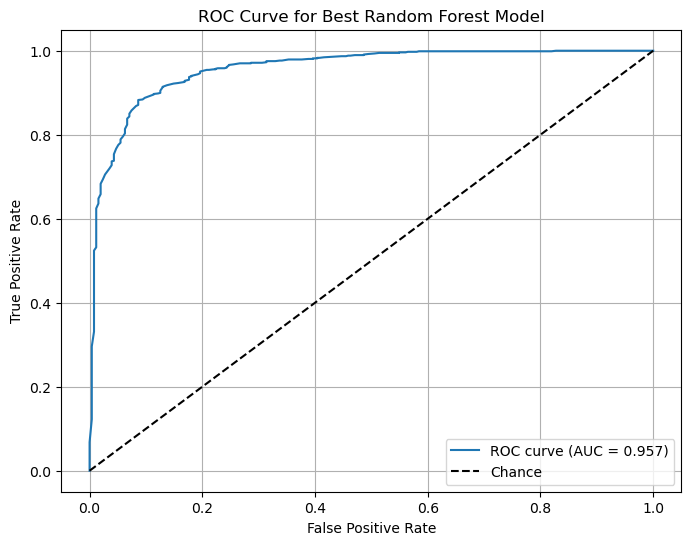

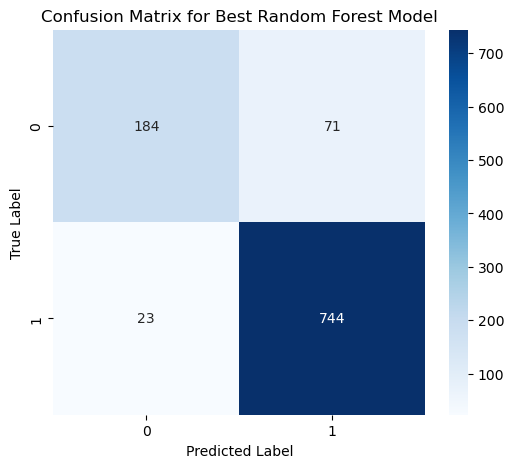

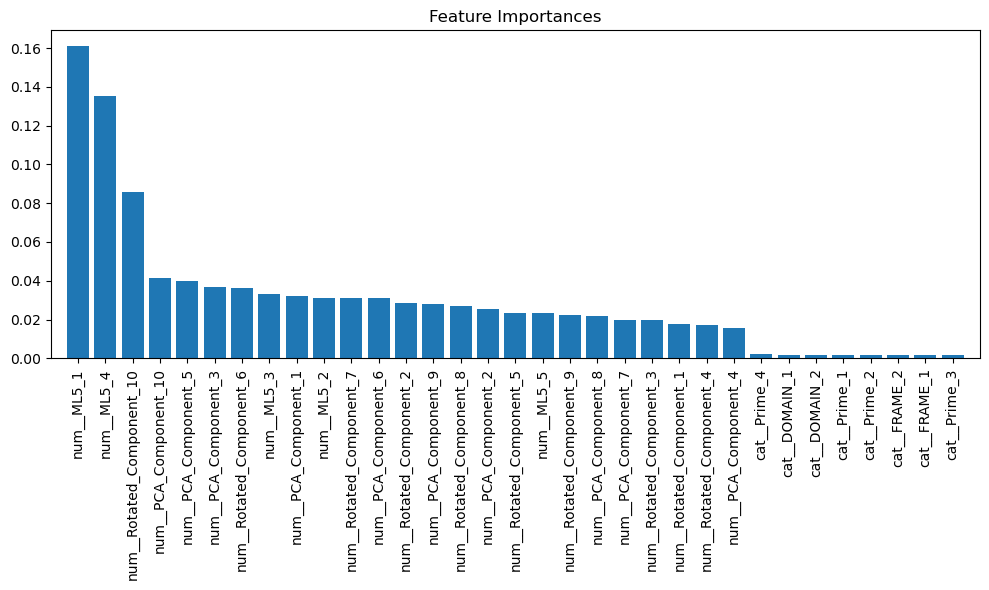

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv(r"V:\20240920\all_in_one_act3301\R_FactorAnalysis\data_all_with_factors_5.csv", 
                 encoding='latin-1', low_memory=False)

# Correct the mistake in the original source file
df['coding1'] = df['coding1'].replace('--1', '-1')

# Filter out rows where the dependent variable 'coding1' is "unknown"
df = df[df['coding1'] != "unknown"]

# Define desired features
desired_features = ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5'] + \
                   [f'PCA_Component_{i}' for i in range(1, 11)] + \
                   [f'Rotated_Component_{i}' for i in range(1, 11)] + \
                   ['Prime', 'DOMAIN', 'FRAME']

feature_cols = [col for col in desired_features if col in df.columns]
print("Using feature columns:", feature_cols)

# Set the dependent variable
target_col = 'coding1'

# Encode the dependent variable (e.g., support -> 1, not support -> 0)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print("Encoded classes for 'coding1':", le.classes_)

# Identify categorical and numerical columns
categorical_cols = ['Prime', 'DOMAIN', 'FRAME']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

# Create a preprocessor for handling categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

# Define the hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Candidate test set sizes to evaluate
test_sizes = [0.2, 0.25, 0.3]
results = []

for test_size in test_sizes:
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_cols], df[target_col], test_size=test_size, random_state=42, stratify=df[target_col]
    )
    
    # Create a pipeline with preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # Perform Grid Search with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid={'classifier__' + k: v for k, v in param_grid.items()},
        cv=5,                       # 5-fold cross-validation
        scoring='accuracy',         # Evaluation metric
        n_jobs=-1                   # Use all available CPU cores
    )
    grid_search.fit(X_train, y_train)
    
    # Get the best model
    best_pipeline = grid_search.best_estimator_
    best_rf = best_pipeline.named_steps['classifier']
    
    # Make predictions
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'test_size': test_size,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': grid_search.best_params_,
        'model': best_rf,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'pipeline': best_pipeline
    })

# Function to compute average score
def avg_score(result):
    return (result['accuracy'] + result['f1_score'] + result['roc_auc']) / 3

# Find the best result
best_result = max(results, key=avg_score)

# Print results
print("Best test split size:", best_result['test_size'])
print("Best model performance:")
print("  Accuracy:", best_result['accuracy'])
print("  F1-score:", best_result['f1_score'])
print("  ROC-AUC:", best_result['roc_auc'])
print("Best hyperparameters:", best_result['best_params'])

# --- Visualization Section ---

# Plot ROC Curve
fpr, tpr, _ = roc_curve(best_result['y_test'], best_result['y_prob'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {best_result["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(best_result['y_test'], best_result['y_pred'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Feature Importances
best_model = best_result['model']
importances = best_model.feature_importances_
feature_names = best_result['pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()

### 列出不同test_size得到的模型的结果

In [2]:
# results 是保存模型结果的字典列表
extracted_values = []
for result in results:
    test_size = result['test_size']
    accuracy = result['accuracy']
    f1_score = result['f1_score']
    roc_auc = result['roc_auc']
    extracted_values.append({
        'test_size': test_size,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'roc_auc': roc_auc
    })

extracted_values

[{'test_size': 0.2,
  'accuracy': 0.9080234833659491,
  'f1_score': 0.9405815423514539,
  'roc_auc': 0.9570416954265408},
 {'test_size': 0.25,
  'accuracy': 0.9045383411580594,
  'f1_score': 0.9383838383838384,
  'roc_auc': 0.951771862670428},
 {'test_size': 0.3,
  'accuracy': 0.9067188519243313,
  'f1_score': 0.9399412011759765,
  'roc_auc': 0.9563809740038598}]

## 2.Use RandomizedSearchCV instead of GridSearchCV
`RandomizedSearchCV` performs random sampling of the hyperparameter space, which can be much faster than exhaustive search with `GridSearchCV`. 
You can specify how many combinations to try by setting the `n_iter` parameter.

Using feature columns: ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5', 'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3', 'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6', 'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_10', 'Rotated_Component_1', 'Rotated_Component_2', 'Rotated_Component_3', 'Rotated_Component_4', 'Rotated_Component_5', 'Rotated_Component_6', 'Rotated_Component_7', 'Rotated_Component_8', 'Rotated_Component_9', 'Rotated_Component_10', 'Prime', 'DOMAIN', 'FRAME']
Encoded classes for 'coding1': ['-1' '1']
Best test split size: 0.2
Best model performance:
  Accuracy: 0.9080234833659491
  F1-score: 0.9405815423514539
  ROC-AUC: 0.9570416954265408
Best hyperparameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 50}


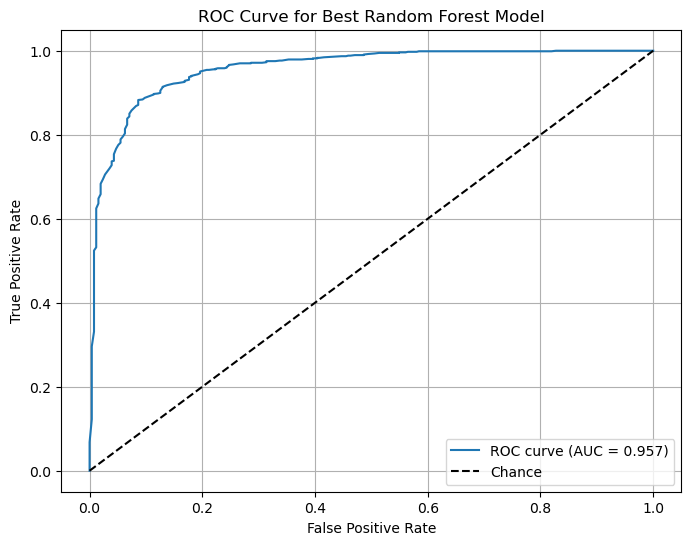

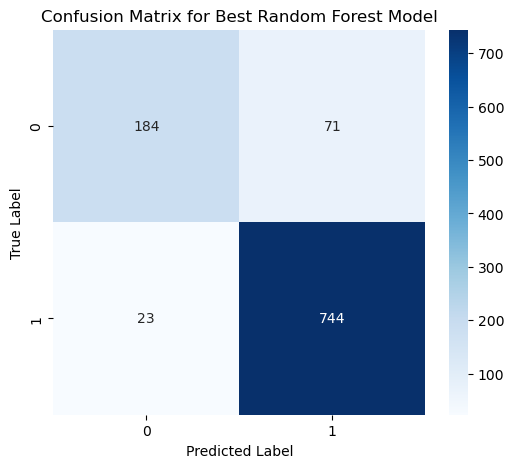

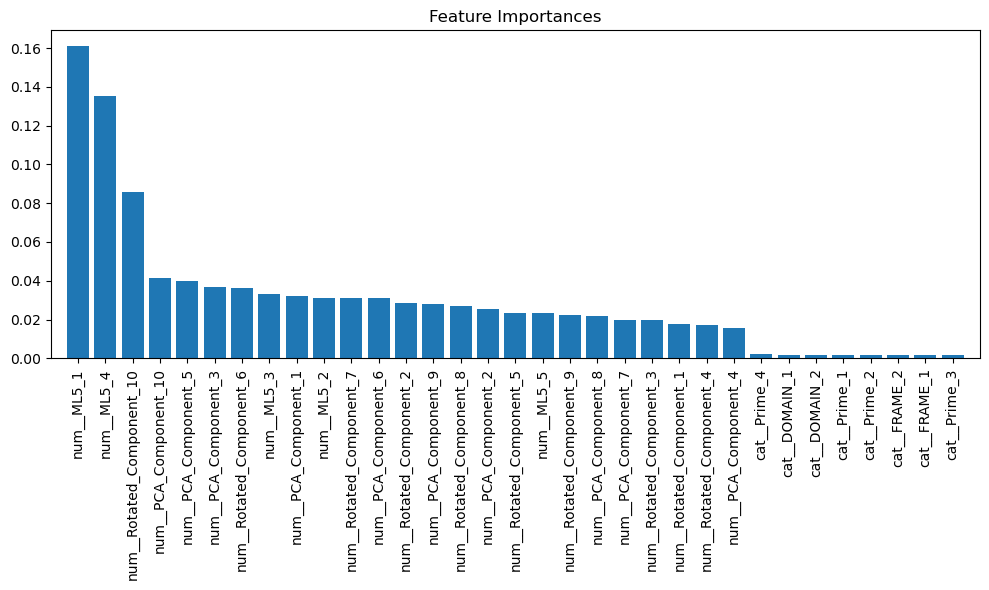

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Load the dataset
df = pd.read_csv(r"V:\20240920\all_in_one_act3301\R_FactorAnalysis\data_all_with_factors_5.csv", 
                 encoding='latin-1', low_memory=False)

# Correct the mistake in the original source file
df['coding1'] = df['coding1'].replace('--1', '-1')

# Filter out rows where the dependent variable 'coding1' is "unknown"
df = df[df['coding1'] != "unknown"]

# Define desired features
desired_features = ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5'] + \
                   [f'PCA_Component_{i}' for i in range(1, 11)] + \
                   [f'Rotated_Component_{i}' for i in range(1, 11)] + \
                   ['Prime', 'DOMAIN', 'FRAME']

feature_cols = [col for col in desired_features if col in df.columns]
print("Using feature columns:", feature_cols)

# Set the dependent variable
target_col = 'coding1'

# Encode the dependent variable (e.g., support -> 1, not support -> 0)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print("Encoded classes for 'coding1':", le.classes_)

# Identify categorical and numerical columns
categorical_cols = ['Prime', 'DOMAIN', 'FRAME']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

# Create a preprocessor for handling categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

# Define the parameter distributions (instead of a grid)
param_dist = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],  # Random sampling over these values
    'classifier__max_depth': [None, 10, 20, 30, 50],
    'classifier__min_samples_split': [2, 5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 4, 6]
}

# Candidate test set sizes to evaluate
test_sizes = [0.2, 0.25, 0.3]
results = []

for test_size in test_sizes:
    # Split the data with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        df[feature_cols], df[target_col], test_size=test_size, random_state=42, stratify=df[target_col]
    )
    
    # Create a pipeline with preprocessing and classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
    
    # Perform RandomizedSearchCV with 5-fold cross-validation
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_dist,
        n_iter=100,                    # Number of random combinations to try
        cv=5,                          # 5-fold cross-validation
        scoring='accuracy',           # Evaluation metric
        n_jobs=-1,                     # Use all available CPU cores
        random_state=42               # Set random seed for reproducibility
    )
    
    random_search.fit(X_train, y_train)
    
    # Get the best model
    best_pipeline = random_search.best_estimator_
    best_rf = best_pipeline.named_steps['classifier']
    
    # Make predictions
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    results.append({
        'test_size': test_size,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': random_search.best_params_,
        'model': best_rf,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'pipeline': best_pipeline
    })

# Function to compute average score
def avg_score(result):
    return (result['accuracy'] + result['f1_score'] + result['roc_auc']) / 3

# Find the best result
best_result = max(results, key=avg_score)

# Print results
print("Best test split size:", best_result['test_size'])
print("Best model performance:")
print("  Accuracy:", best_result['accuracy'])
print("  F1-score:", best_result['f1_score'])
print("  ROC-AUC:", best_result['roc_auc'])
print("Best hyperparameters:", best_result['best_params'])

# --- Visualization Section ---

# Plot ROC Curve
fpr, tpr, _ = roc_curve(best_result['y_test'], best_result['y_prob'])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {best_result["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(best_result['y_test'], best_result['y_pred'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Feature Importances
best_model = best_result['model']
importances = best_model.feature_importances_
feature_names = best_result['pipeline'].named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()

### 列出不同test_size得到的模型的结果

In [10]:
# results 是保存模型结果的字典列表
extracted_values = []
for result in results:
    test_size = result['test_size']
    accuracy = result['accuracy']
    f1_score = result['f1_score']
    roc_auc = result['roc_auc']
    extracted_values.append({
        'test_size': test_size,
        'accuracy': accuracy,
        'f1_score': f1_score,
        'roc_auc': roc_auc
    })

extracted_values

[{'test_size': 0.2,
  'accuracy': 0.9080234833659491,
  'f1_score': 0.9405815423514539,
  'roc_auc': 0.9570416954265408},
 {'test_size': 0.25,
  'accuracy': 0.9045383411580594,
  'f1_score': 0.9383838383838384,
  'roc_auc': 0.9522213251133462},
 {'test_size': 0.3,
  'accuracy': 0.9080234833659491,
  'f1_score': 0.9407811843763125,
  'roc_auc': 0.9562651833352253}]

## 3.Hyperband or Bayesian optimization
If you're looking for more advanced and efficient ways of tuning hyperparameters, consider using algorithms like Hyperband or Bayesian Optimization. These methods can intelligently explore the hyperparameter space based on past trials, avoiding the exhaustive search of `GridSearchCV`.

- **Hyperband**: Uses early stopping to allocate resources to promising configurations and avoids wasting resources on poor-performing ones.
- **Bayesian Optimization**: Uses probability models to choose promising hyperparameters to explore.

### 3.1 Bayesian Optimization

[I 2025-03-02 11:01:22,986] A new study created in memory with name: no-name-c3a96e4f-4c76-424d-a377-f71067c86359


Using feature columns: ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5', 'PCA_Component_1', 'PCA_Component_2', 'PCA_Component_3', 'PCA_Component_4', 'PCA_Component_5', 'PCA_Component_6', 'PCA_Component_7', 'PCA_Component_8', 'PCA_Component_9', 'PCA_Component_10', 'Rotated_Component_1', 'Rotated_Component_2', 'Rotated_Component_3', 'Rotated_Component_4', 'Rotated_Component_5', 'Rotated_Component_6', 'Rotated_Component_7', 'Rotated_Component_8', 'Rotated_Component_9', 'Rotated_Component_10', 'Prime', 'DOMAIN', 'FRAME']
Encoded classes for 'coding1': ['-1' '1']


[I 2025-03-02 11:01:24,982] Trial 0 finished with value: 0.9099800757901317 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9099800757901317.
[I 2025-03-02 11:01:27,048] Trial 1 finished with value: 0.9094210259014728 and parameters: {'n_estimators': 200, 'max_depth': 23, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9099800757901317.
[I 2025-03-02 11:01:29,974] Trial 2 finished with value: 0.9108204086416377 and parameters: {'n_estimators': 300, 'max_depth': 28, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9108204086416377.
[I 2025-03-02 11:01:33,269] Trial 3 finished with value: 0.8973977419228815 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9108204086416377.
[I 2025-03-02 11:01:34,237] Trial 4 finished with value: 0.9097015275227566 and parameters: {

Best hyperparameters: {'n_estimators': 400, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 1}
Best score (accuracy): 0.9183673868031409
Best model performance:
  Accuracy: 0.908675799086758
  F1-score: 0.9411269974768713
  ROC-AUC: 0.954187762515609


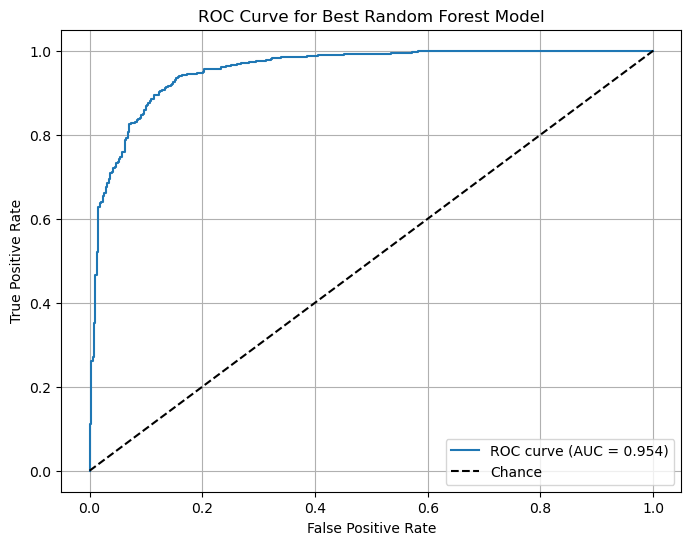

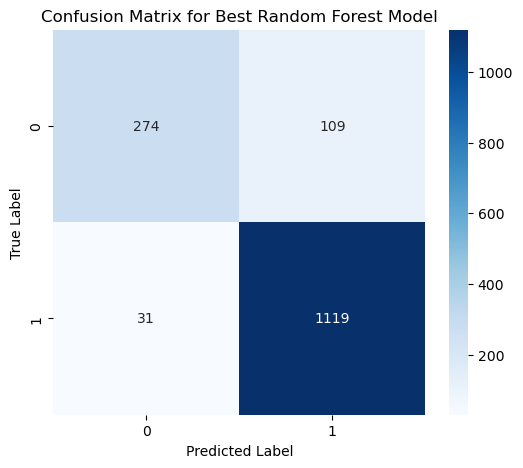

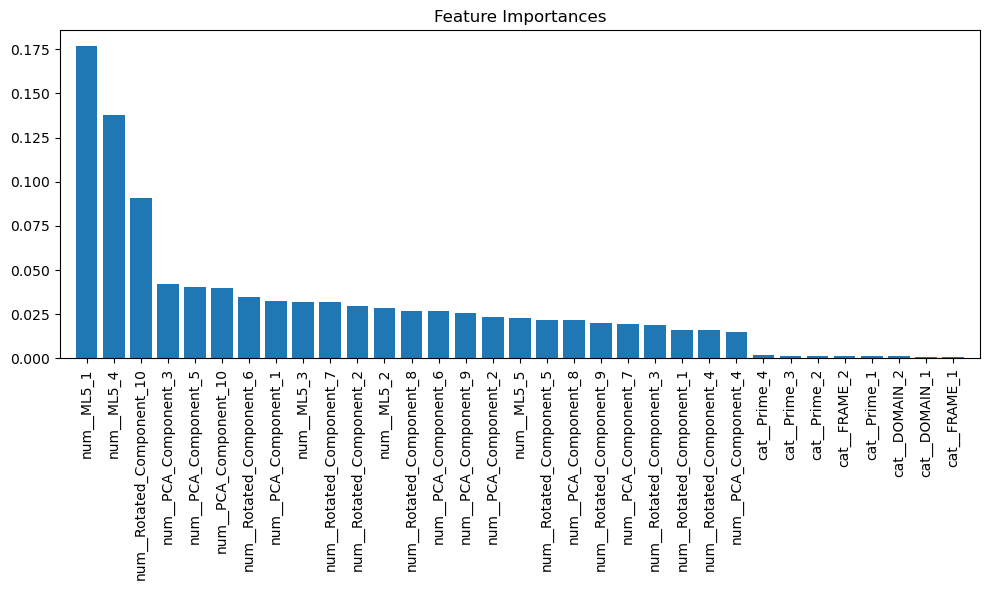

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import optuna
from sklearn.model_selection import cross_val_score

# Load the dataset
df = pd.read_csv(r"V:\20240920\all_in_one_act3301\R_FactorAnalysis\data_all_with_factors_5.csv", 
                 encoding='latin-1', low_memory=False)

# Correct the mistake in the original source file
df['coding1'] = df['coding1'].replace('--1', '-1')

# Filter out rows where the dependent variable 'coding1' is "unknown"
df = df[df['coding1'] != "unknown"]

# Define desired features
desired_features = ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5'] + \
                   [f'PCA_Component_{i}' for i in range(1, 11)] + \
                   [f'Rotated_Component_{i}' for i in range(1, 11)] + \
                   ['Prime', 'DOMAIN', 'FRAME']

feature_cols = [col for col in desired_features if col in df.columns]
print("Using feature columns:", feature_cols)

# Set the dependent variable
target_col = 'coding1'

# Encode the dependent variable (e.g., support -> 1, not support -> 0)
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])
print("Encoded classes for 'coding1':", le.classes_)

# Identify categorical and numerical columns
categorical_cols = ['Prime', 'DOMAIN', 'FRAME']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

# Create a preprocessor for handling categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])


# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500])
    max_depth = trial.suggest_int('max_depth', 5, 30)  # Explore depths from 5 to 30
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Explore min_samples_split between 2 and 10
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)  # Explore min_samples_leaf between 1 and 5
    
    # Create a RandomForestClassifier with the selected hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # Perform cross-validation and return the mean accuracy
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=5, scoring='accuracy').mean()
    
    return score  # Optuna will try to maximize this score

# Create the study to optimize the objective function
study = optuna.create_study(direction='maximize')  # We want to maximize accuracy
study.optimize(objective, n_trials=50)  # Run 50 trials of the optimization process

# Print the best hyperparameters and best score found
print("Best hyperparameters:", study.best_params)
print("Best score (accuracy):", study.best_value)

# Retrieve the best model using the best parameters found
best_params = study.best_params
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Create a pipeline with preprocessing and the best RandomForest model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_rf)
])

# Fit the best model
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Best model performance:")
print("  Accuracy:", accuracy)
print("  F1-score:", f1)
print("  ROC-AUC:", roc_auc)

# --- Visualization Section ---

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Feature Importances
importances = best_rf.feature_importances_
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()


### 3.2 Hyperband - incomplete
To use **Hyperband** in your code for hyperparameter tuning, we can leverage the `Hyperopt` library or `optuna`. However, one of the most popular frameworks for Hyperband is `Ray Tune`, which is part of the **Ray** ecosystem and integrates well with many machine learning frameworks, including scikit-learn.

In this case, we will use **Ray Tune** for Hyperband optimization, as it is built specifically to handle hyperparameter optimization using efficient algorithms like Hyperband.

```
pip install ray[tune]
```

In [6]:
import ray
from ray import tune
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Load the dataset (update path if needed)
df = pd.read_csv(r"V:\20240920\all_in_one_act3301\R_FactorAnalysis\data_all_with_factors_5.csv", encoding='latin-1', low_memory=False)
df['coding1'] = df['coding1'].replace('--1', '-1')
df = df[df['coding1'] != "unknown"]

# Define the features and target
target_col = 'coding1'
feature_cols = ['ML5_1', 'ML5_2', 'ML5_3', 'ML5_4', 'ML5_5'] + \
               [f'PCA_Component_{i}' for i in range(1, 11)] + \
               [f'Rotated_Component_{i}' for i in range(1, 11)] + \
               ['Prime', 'DOMAIN', 'FRAME']

# Preprocessing pipeline for categorical features
categorical_cols = ['Prime', 'DOMAIN', 'FRAME']
numerical_cols = [col for col in feature_cols if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numerical_cols)
    ])

# Label encoding for the target variable
le = LabelEncoder()
df[target_col] = le.fit_transform(df[target_col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_cols], df[target_col], test_size=0.2, random_state=42, stratify=df[target_col]
)

# Define the search space for Hyperband
search_space = {
    'n_estimators': tune.choice([100, 200, 300, 400, 500]),
    'max_depth': tune.randint(5, 30),
    'min_samples_split': tune.randint(2, 10),
    'min_samples_leaf': tune.randint(1, 5)
}

# Define the training function for Ray Tune
def train_rf(config, checkpoint_dir=None):
    # Create the RandomForest model with the current hyperparameters
    model = RandomForestClassifier(
        n_estimators=config['n_estimators'],
        max_depth=config['max_depth'],
        min_samples_split=config['min_samples_split'],
        min_samples_leaf=config['min_samples_leaf'],
        random_state=42
    )
    
    # Create a pipeline with preprocessing and the classifier
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Return the evaluation metrics to Ray Tune
    tune.report(accuracy=accuracy, f1=f1, roc_auc=roc_auc)

# Initialize Ray
ray.init(ignore_reinit_error=True)

# Run Hyperband optimization using Ray Tune
analysis = tune.run(
    train_rf,
    resources_per_trial={"cpu": 2},  # Adjust the CPU resources as needed
    config=search_space,
    num_samples=10,  # Number of random samples for Hyperband
    metric="accuracy",  # Optimizing for accuracy
    mode="max",  # Maximize the accuracy
    scheduler=tune.schedulers.HyperBandScheduler(metric="accuracy", mode="max"),
    name="hyperband_rf"
)

# Get the best trial's hyperparameters
best_trial = analysis.get_best_trial("accuracy", "max")
best_params = best_trial.config
print(f"Best hyperparameters: {best_params}")

# Re-train the best model with the optimal hyperparameters
best_rf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Create a pipeline with preprocessing and the best model
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_rf)
])

# Fit the best model
best_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Best model performance:")
print("  Accuracy:", accuracy)
print("  F1-score:", f1)
print("  ROC-AUC:", roc_auc)

# --- Visualization Section ---

# Plot ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot Feature Importances
import numpy as np

importances = best_rf.feature_importances_
feature_names = best_pipeline.named_steps['preprocessor'].get_feature_names_out()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()


2025-03-02 11:13:09,909	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-02 11:13:11,236	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


ValueError: You passed a `metric` or `mode` argument to `tune.run(...)`, but the scheduler you are using was already instantiated with their own `metric` and `mode` parameters. Either remove the arguments from your scheduler or from `tune.run(...)` args.

(train_rf pid=19816) Error in train_rf: report() got an unexpected keyword argument 'accuracy'
(train_rf pid=20040) Error in train_rf: report() got an unexpected keyword argument 'accuracy' [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_rf pid=21972) Error in train_rf: report() got an unexpected keyword argument 'accuracy' [repeated 5x across cluster]


# test